### Part 3

#### Preparation

In [ ]:
# Helper code session (Copied from pokedex_helper):
!pip install datasets transformers numpy pandas Pillow matplotlib 
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7s37iujr
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7s37iujr
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=5e4dffa71da95319f3c16d68c90b719283b589d9f085f3e96d7df8fab3a8d3c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbfk4xm6/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [32]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [21]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]
            
    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neåighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [ ]:
# Part 3 dataset download

! pip install -q kaggle
import kagglehub
path = kagglehub.dataset_download("hlrhegemony/pokemon-image-dataset")
print("Path to dataset files:", path)
!wget -O Pokemon.csv https://raw.githubusercontent.com/lgreski/pokemonData/master/Pokemon.csv


Using Colab cache for faster access to the 'pokemon-image-dataset' dataset.
Path to dataset files: /kaggle/input/pokemon-image-dataset
--2026-02-11 00:42:53--  https://raw.githubusercontent.com/lgreski/pokemonData/master/Pokemon.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74060 (72K) [text/plain]
Saving to: ‘Pokemon.csv’

Pokemon.csv         100%[===================>]  72.32K  --.-KB/s    in 0.002s  

2026-02-11 00:42:53 (28.9 MB/s) - ‘Pokemon.csv’ saved [74060/74060]



In [ ]:
# Part 3 Dataset read
IMAGE_ROOT = "/kaggle/input/pokemon-image-dataset/images"

pokedex = construct_pokedex(
    csv_path="Pokemon.csv",
    image_dir=IMAGE_ROOT, # path of download, should be modified, see output of Path to dataset files
    type_to_load=None
)

# ensure the structure of the datasets
print("pokedex shape:", pokedex.shape)
print(pokedex[["Name","Type1","Type2","image_path"]].head())
print("Type1 counts top10:\n", pokedex["Type1"].value_counts().head(10))


pokedex shape: (754, 14)
         Name  Type1   Type2  \
0   Bulbasaur  Grass  Poison   
1     Ivysaur  Grass  Poison   
2  Charmander   Fire           
3  Charmeleon   Fire           
4    Squirtle  Water           

                                          image_path  
0  /kaggle/input/pokemon-image-dataset/images/Bul...  
1  /kaggle/input/pokemon-image-dataset/images/Ivy...  
2  /kaggle/input/pokemon-image-dataset/images/Cha...  
3  /kaggle/input/pokemon-image-dataset/images/Cha...  
4  /kaggle/input/pokemon-image-dataset/images/Squ...  
Type1 counts top10:
 Type1
Water       106
Normal       92
Grass        79
Bug          69
Psychic      46
Fire         44
Rock         41
Electric     38
Fighting     32
Dark         30
Name: count, dtype: int64


In [ ]:
import os
# load model and retrieve image embeds
model, preprocess, device = load_clip_model()

CACHE_PATH = "clip_image_embeds_vitl14.npy"
image_paths = pokedex["image_path"].tolist()

if os.path.exists(CACHE_PATH):
    image_embeds = np.load(CACHE_PATH)
    print("Loaded cached embeddings:", image_embeds.shape)
else:
    image_embeds = clip_inference_image(model, preprocess, image_paths, device)
    np.save(CACHE_PATH, image_embeds)
    print("Saved embeddings:", image_embeds.shape)


100%|███████████████████████████████████████| 890M/890M [00:10<00:00, 87.0MiB/s]
100%|██████████| 754/754 [36:59<00:00,  2.94s/it]

Saved embeddings: (754, 768)


#### Question 20

Selected template: {t} Pokemon
Average hit rate: 0.9666666666666667
Per-type hit rate: {'Bug': np.float64(0.95), 'Fire': np.float64(1.0), 'Grass': np.float64(0.95)}


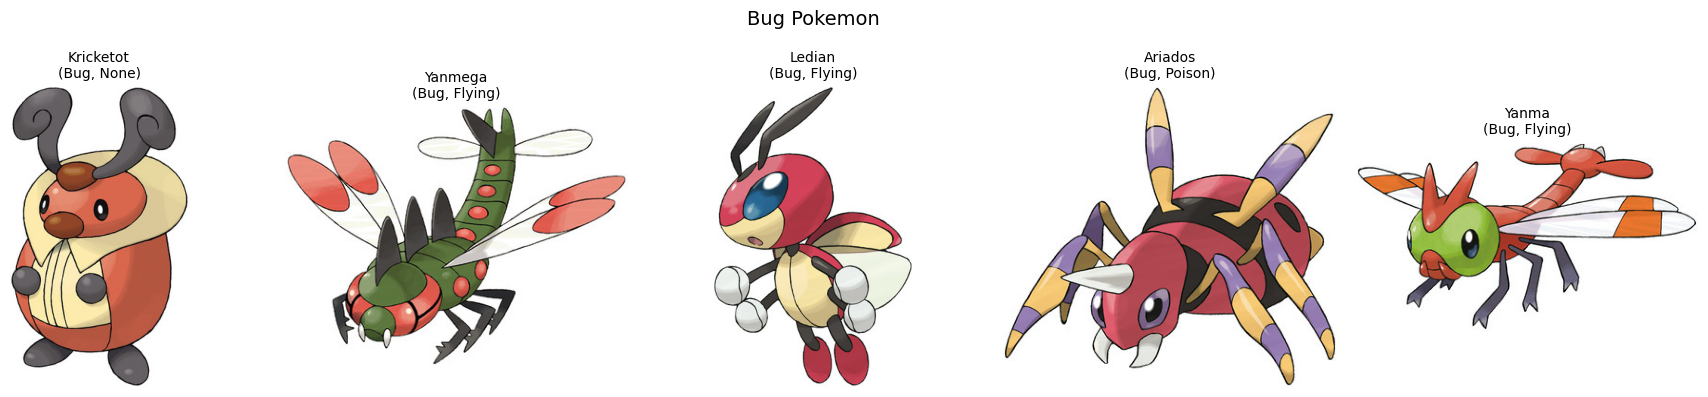

Type Bug hit rate at 5: 1.0


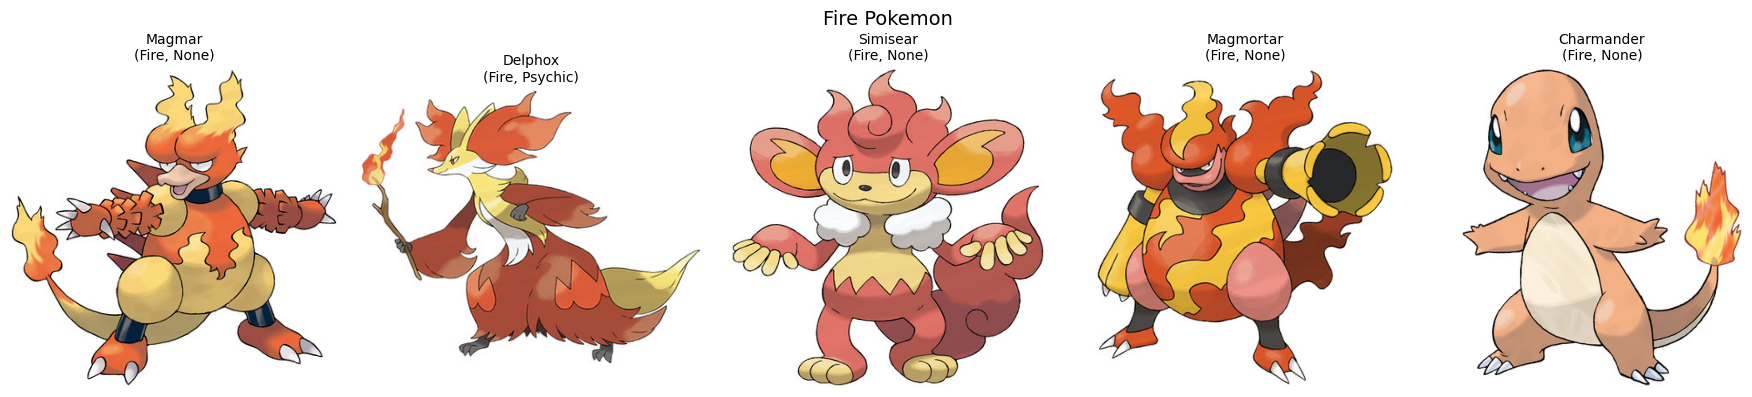

Type Fire hit rate at 5: 1.0


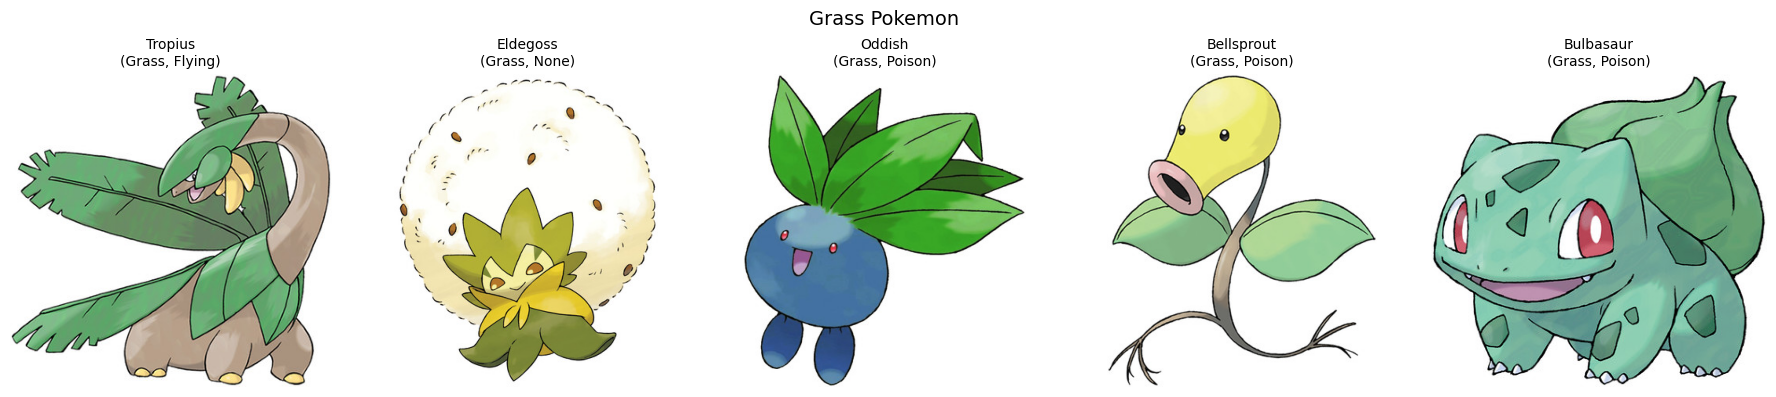

Type Grass hit rate at 5: 1.0


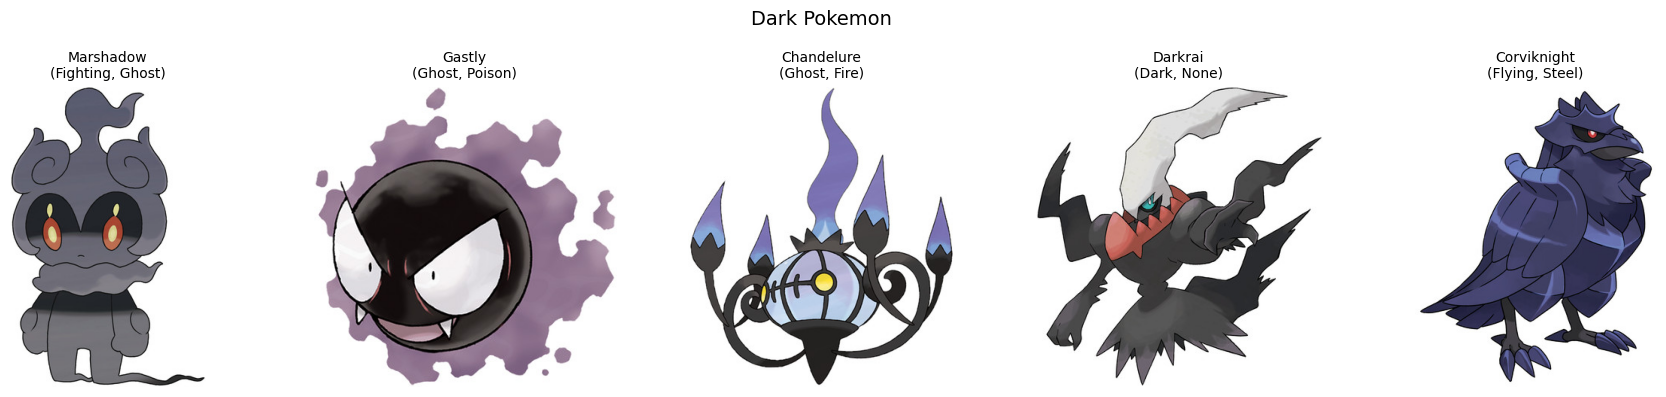

Type Dark hit rate at 5: 0.2


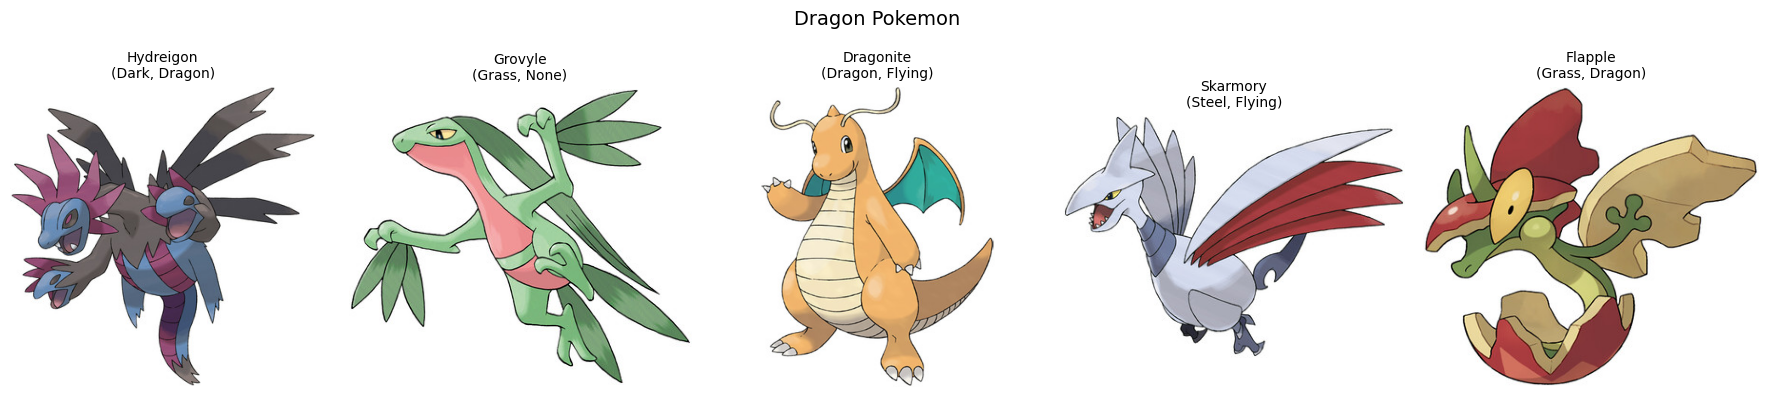

Type Dragon hit rate at 5: 0.6


{'Dark': {'query': 'Dark Pokemon',
  'top_idx': array([666,  59, 499, 391, 687]),
  'scores': array([0.0780279 , 0.04942964, 0.03904572, 0.03872605, 0.03539416],
        dtype=float32),
  'hit@k': 0.2},
 'Dragon': {'query': 'Dragon Pokemon',
  'top_idx': array([523, 191, 100, 167, 705]),
  'scores': array([0.07663282, 0.06542038, 0.06498274, 0.05978835, 0.05878198],
        dtype=float32),
  'hit@k': 0.6}}

In [ ]:
# By default retrieve the top 5 images according to the text embedding
def retrieve(image_embeds, text_embed, k=5): 
    text_embed = np.atleast_2d(text_embed)
    sims = compute_similarity_image_to_text(image_embeddings=image_embeds, text_embeddings=text_embed)
    scores = sims[:, 0]
    top_idx = np.argsort(-scores)[:k] # score descending order, top k
    return top_idx, scores[top_idx]


def plot_top5(pokedex, top_idx, query):
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    fig.suptitle(query, fontsize=14)

    for ax, idx in zip(axes, top_idx):
        row = pokedex.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        ax.imshow(img)
        t2 = row["Type2"] if row["Type2"] != "" else "None"
        ax.set_title(f'{row["Name"]}\n({row["Type1"]}, {t2})', fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def hit_rate_for_type(pokedex, idx_list, poke_type):
    sub = pokedex.iloc[idx_list]
    return ((sub["Type1"] == poke_type) | (sub["Type2"] == poke_type)).mean()

def evaluate_templates(pokedex, image_embeds, poke_types=("Bug", "Fire", "Grass"), topn=20):
    templates = [
        "A photo of {t} type Pokemon",
        "{t} type Pokemon",
        "A Pokemon of type {t}",
        "{t}",
        "{t} Pokemon"
    ]

    # template -> list of hit rate at k over types
    template_scores = {temp: [] for temp in templates}
    per_type_detail = {temp: {} for temp in templates}

    for t in poke_types:
        for temp in templates:
            query = temp.format(t=t)

            text_embed = clip_inference_text(
                model=model,
                preprocess=preprocess,
                texts=[query],
                device=device,
            )[0]  # (D,)

            top_idx, scores = retrieve(
                image_embeds=image_embeds,
                text_embed=text_embed,
                k=topn,
            )

            hit = hit_rate_for_type(pokedex, top_idx, t)
            template_scores[temp].append(hit)
            per_type_detail[temp][t] = hit

    # select best template with best rit rate
    best_template = max(
        templates,
        key=lambda temp: np.mean(template_scores[temp]),
    )
    best_avg_hit = float(np.mean(template_scores[best_template]))
    per_type_hits = per_type_detail[best_template]

    return best_template, best_avg_hit, per_type_hits, template_scores

def retrieve_and_plot(best_template, poke_types):
    results = {}
    for t in poke_types:
        query = best_template.format(t=t)
        text_embed = clip_inference_text(model=model, preprocess=preprocess, texts=[query], device=device)[0]
        top_idx, scores = retrieve(image_embeds=image_embeds, text_embed=text_embed, k=5)
        plot_top5(pokedex=pokedex, top_idx=top_idx, query=query)
        hit = hit_rate_for_type(pokedex=pokedex, idx_list=top_idx, poke_type=t)
        print(f"Type {t} hit rate at 5: {hit}")
        results[t] = {
            "query": query,
            "top_idx": top_idx,
            "scores": scores,
            "hit@k": float(hit),
        }
    return results

# Template evaluation
best_template, best_avg, per_type_hits, _ = evaluate_templates(
    pokedex,
    image_embeds,
    poke_types=("Bug", "Fire", "Grass"),
    topn=20,
)

print(f"Selected template: {best_template}")
print(f"Average hit rate: {best_avg}")
print(f"Per-type hit rate: {per_type_hits}")

# Retrieve and analyze for the required types
retrieve_and_plot(best_template=best_template, poke_types=("Bug", "Fire", "Grass"))
retrieve_and_plot(best_template=best_template, poke_types=("Dark", "Dragon"))




**Answer Q20**:
- Compared with Fire, Grass and Bug, Dark and Dragon have significantly lower top 5 hit rate. This is probably because of the mismatch between appearnace and type definition: Many Pokémon has dragon-like or dark-looking visual characteristics but are not classified as Dragon or Dark type officially (Grovyle, Chandelure). CLIP tends to retrieve Pokemon based on their visual and semantic resemblance instead of the type labels, leading to the lower top 5 hit rate than Bug, Fire and Grass.